In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit, minimize
from scipy.integrate import solve_ivp, odeint
import numpy as np
import random

# Helper Functions

In [3]:
def sir_model(t, y, beta, gamma):
    '''' y is tuple with 
    (S, I, R) - > (Voters (infuencible), Opioniated voters (voter percentage for chosen candidate), Recovered (Voters who change sides) 
    
    '''
    S, I, R = y
    dSdt = -beta * S * I # It can go both ways ? 
    dIdt = beta * S * I - gamma * I # what is the mechanism for this. What is gamma a function of ? 
    dRdt = gamma * I # potenitally, beta and gamma are funcitons of time ? 
    return [dSdt, dIdt, dRdt]

In [4]:
def fit_sir_model(t, beta, gamma, S0, I0, R0):
    '''What is the return value?'''
    sol = solve_ivp(sir_model, [t[0], t[-1]], [S0, I0, R0], t_eval=t, args=(beta, gamma))
    return sol.y[1] # returns S, I, R as they change wrt time. y[1] gives I 

In [5]:
def sir_model1(y, t, beta, gamma, N):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

In [6]:
def sir_model2(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I  - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

In [7]:
def fitness_function(params, t, data_I, N):
    beta, gamma = params
    S0, I0, R0 = N - data_I[0], data_I[0], 0  # Assume S0 is total population minus initial I
    y0 = S0, I0, R0

    # Solve ODEs
    sol = odeint(sir_model1, y0, t, args=(beta, gamma, N))

    # Compute the squared error for the infected population
    I_model = sol[:, 1]  # Extract the infected population from the model
    error_I = np.sum((I_model - data_I) ** 2)

    return error_I,

In [8]:
def loss(params, t, R_data, I0=0.01):
    beta, gamma = params
    S0 = 1 - I0
    y0 = [S0, I0, 0.0]
    sol = odeint(sir_model2, y0, t, args=(beta, gamma))
    R_pred = sol[:, 2]
    return np.mean((R_pred - R_data) ** 2)

# Data Visualization

In [9]:
df = pd.read_csv("1976-2020-senate.csv")

In [10]:
df

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,special,candidate,party_detailed,writein,mode,candidatevotes,totalvotes,unofficial,version,party_simplified
0,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,SAM STEIGER,REPUBLICAN,False,total,321236,741210,False,20210114,REPUBLICAN
1,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,WM. MATHEWS FEIGHAN,INDEPENDENT,False,total,1565,741210,False,20210114,OTHER
2,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,DENNIS DECONCINI,DEMOCRAT,False,total,400334,741210,False,20210114,DEMOCRAT
3,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,ALLAN NORWITZ,LIBERTARIAN,False,total,7310,741210,False,20210114,LIBERTARIAN
4,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,BOB FIELD,INDEPENDENT,False,total,10765,741210,False,20210114,OTHER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3625,2020,WYOMING,WY,56,83,68,US SENATE,statewide,gen,False,UNDER VOTES,NaN,False,total,6401,278503,False,20210114,OTHER
3626,2021,GEORGIA,GA,13,58,44,US SENATE,statewide,runoff,True,KELLY LOEFFLER,REPUBLICAN,False,total,2194848,4483294,True,20210114,REPUBLICAN
3627,2021,GEORGIA,GA,13,58,44,US SENATE,statewide,runoff,True,RAPHAEL WARNOCK,DEMOCRAT,False,total,2288446,4483294,True,20210114,DEMOCRAT
3628,2021,GEORGIA,GA,13,58,44,US SENATE,statewide,runoff,False,DAVID A. PERDUE,REPUBLICAN,False,total,2213979,4483241,True,20210114,REPUBLICAN


In [11]:
selected_states = ['NEW HAMPSHIRE', 'NORTH CAROLINA', 'OKLAHOMA', 'OREGON', 'SOUTH CAROLINA', 'SOUTH DAKOTA']
filtered_df = df[df['state'].isin(selected_states)]

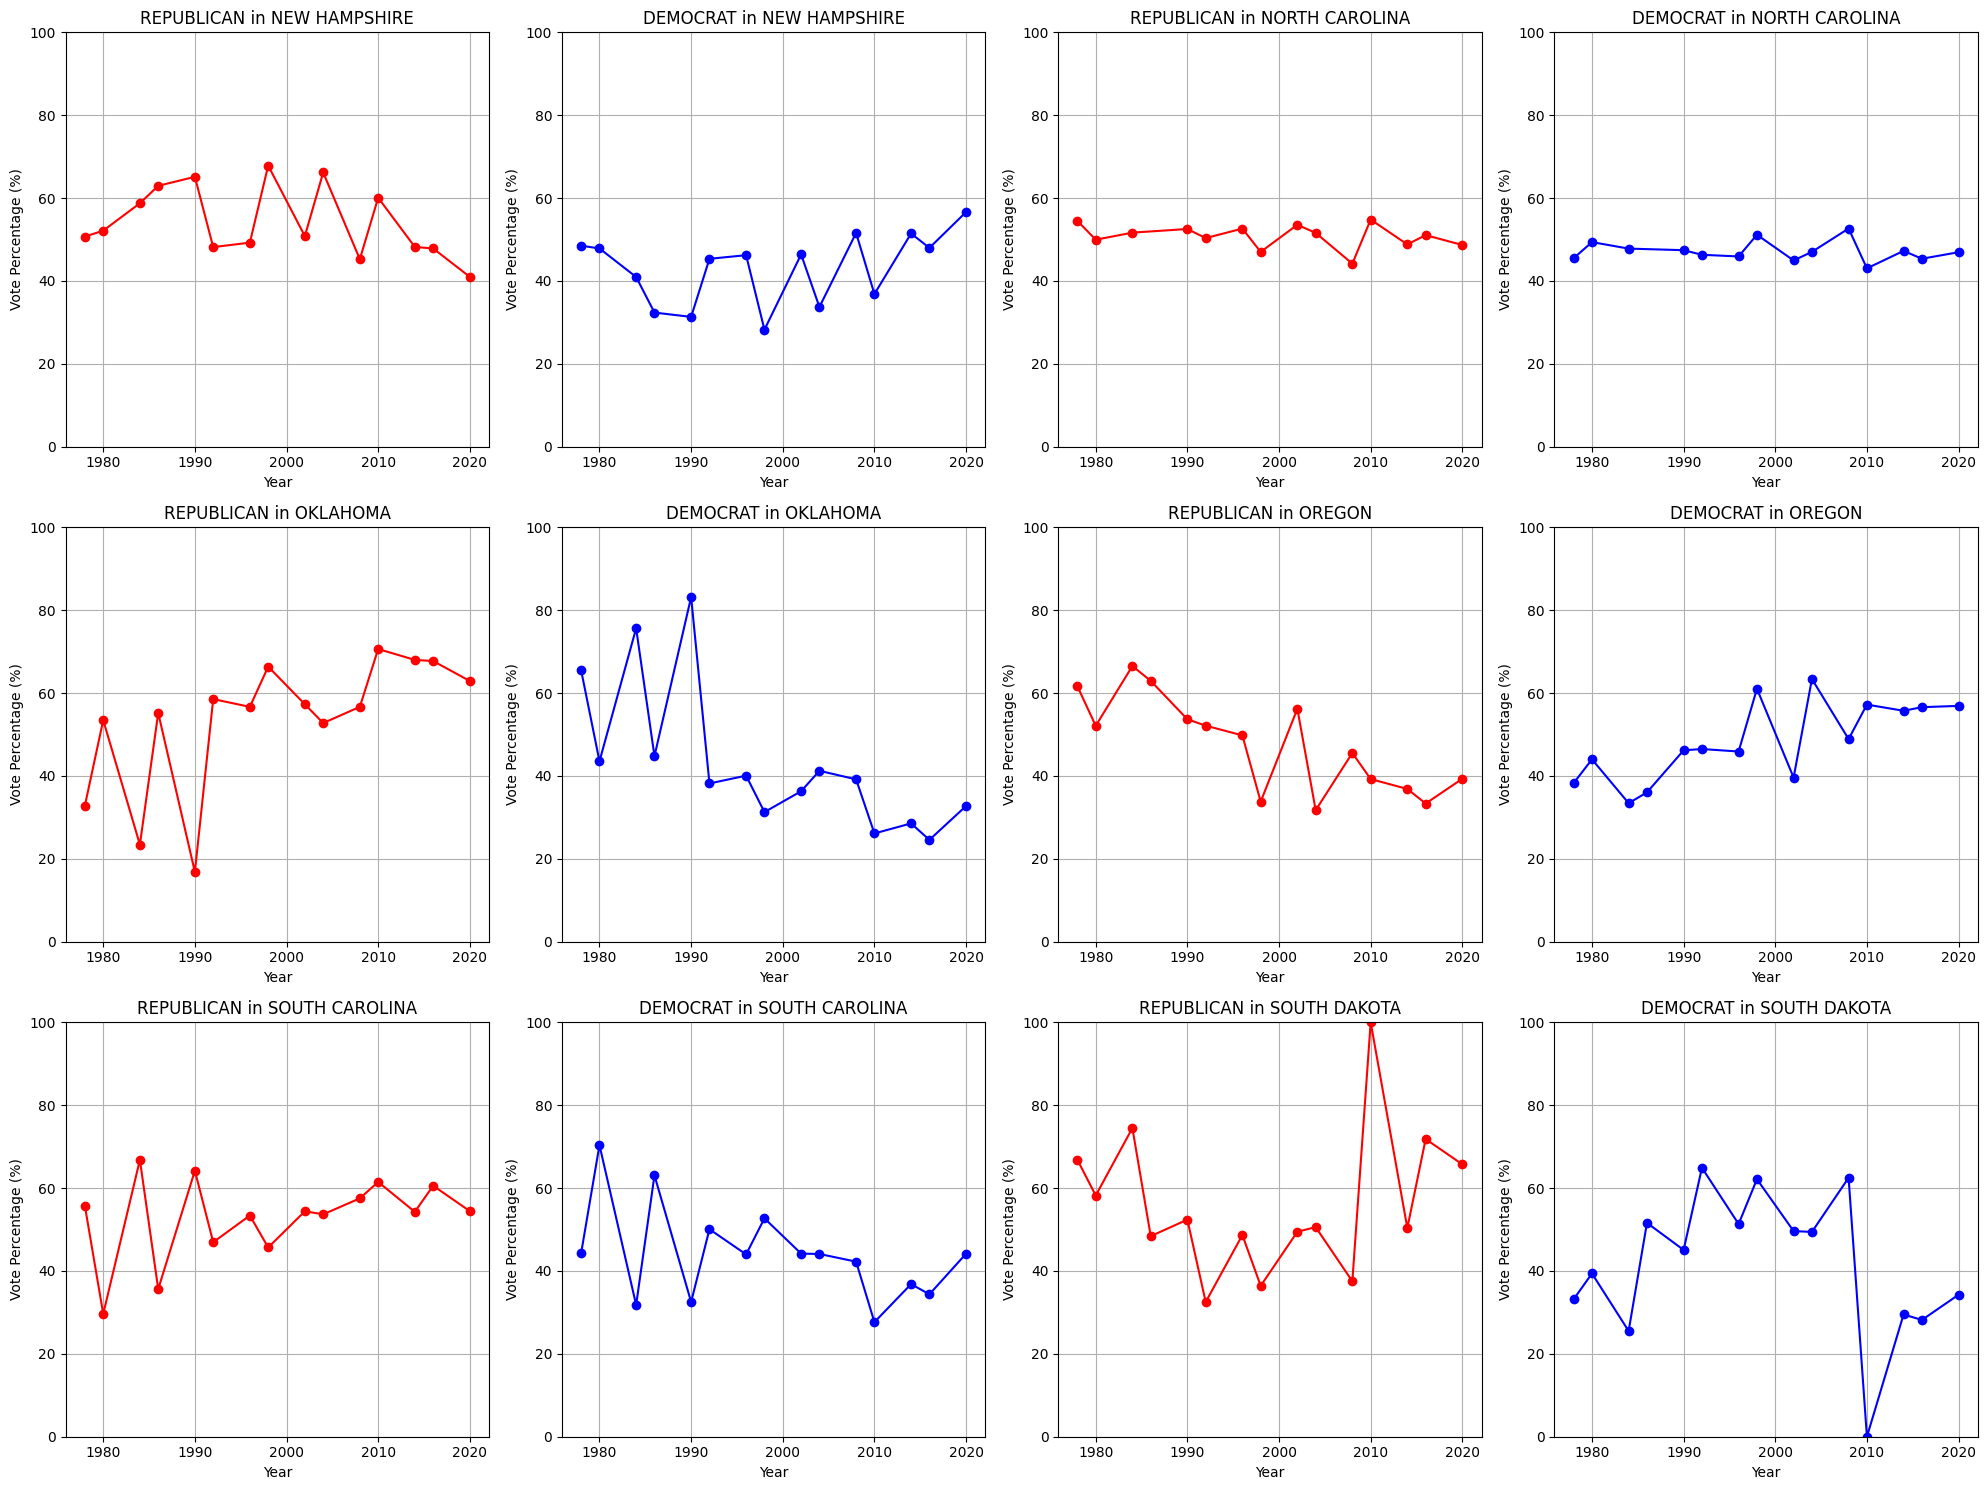

In [12]:
states = filtered_df['state'].unique()
party_order = ['REPUBLICAN', 'DEMOCRAT']
colors = {'REPUBLICAN': 'red', 'DEMOCRAT': 'blue'} # BONUS 
df_dict = {}
num_plots = len(states) * len(party_order)
cols = 4  # Number of columns in the grid
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()

plot_index = 0
for state in states:
    for party in party_order:
        state_party_data = df[(df['state'] == state) & (df['party_simplified'] == party) & (df['special'] == False)]
        state_party_data = state_party_data[state_party_data['writein'] == False]
        df_dict[(state, party)] = state_party_data
        if not state_party_data.empty:
            ax = axes[plot_index]
            ax.plot(state_party_data['year'], state_party_data['candidatevotes'] / state_party_data['totalvotes'] * 100, marker='o', color=colors[party])
            ax.set_title(f'{party} in {state}')
            ax.set_xlabel('Year')
            ax.set_ylabel('Vote Percentage (%)')
            ax.set_ylim(0, 100)
            ax.grid(True)
            plot_index += 1

# Hide unused subplots
for i in range(plot_index, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# Pearson Coefficient

In [13]:
year1 = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['year'].values
votes1 = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['candidatevotes'].values
total_votes1 = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['totalvotes'].values
vote_percentage1 = votes1 / total_votes1

year = df_dict[('OREGON', 'REPUBLICAN')]['year'].values
votes = df_dict[('OREGON', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('OREGON', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes

correlation = np.corrcoef(vote_percentage, vote_percentage1)[0, 1]
print("Pearson Correlation:", correlation)

Pearson Correlation: 0.01222907607251956


# Fitting with Least Squares

In [14]:
cols = ['year', 'candidatevotes', 'totalvotes']
df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')][cols]

,year,candidatevotes,totalvotes
221,1978,133745,263760
346,1980,195559,375060
607,1984,225828,384369
719,1986,154090,244735
956,1990,189792,291393
1100,1992,249591,518170
1415,1996,242257,491873
1568,1998,213477,314696
1905,2002,227229,447135
2059,2004,434847,657086


In [15]:
year = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['year'].values
votes = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('NEW HAMPSHIRE', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes
I0 = vote_percentage[0]
S0 = 1 - I0
R0 = 0

# fit the curve provided initial guess. 0.1 each | Gives local optimum
params, covariance = curve_fit(fit_sir_model, year, vote_percentage, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
beta, gamma = params[:2]
print(f"Fitted parameters: beta={beta}, gamma={gamma}")

Fitted parameters: beta=0.05437961621978311, gamma=0.03446399192118356


In [16]:
fitted_voter_percentage = fit_sir_model(year, *params)

In [17]:
split_index = int(0.8 * len(year))

X_train, X_test = year[:split_index], year[split_index:]
y_train, y_test = vote_percentage[:split_index], vote_percentage[split_index:]
params, covariance = curve_fit(fit_sir_model, X_train, y_train, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
beta, gamma = params[:2]
print(f"Fitted parameters: beta={beta}, gamma={gamma}")
test_fit = (fit_sir_model(year, *params))


Fitted parameters: beta=0.5672019667303213, gamma=0.0036563196181867703


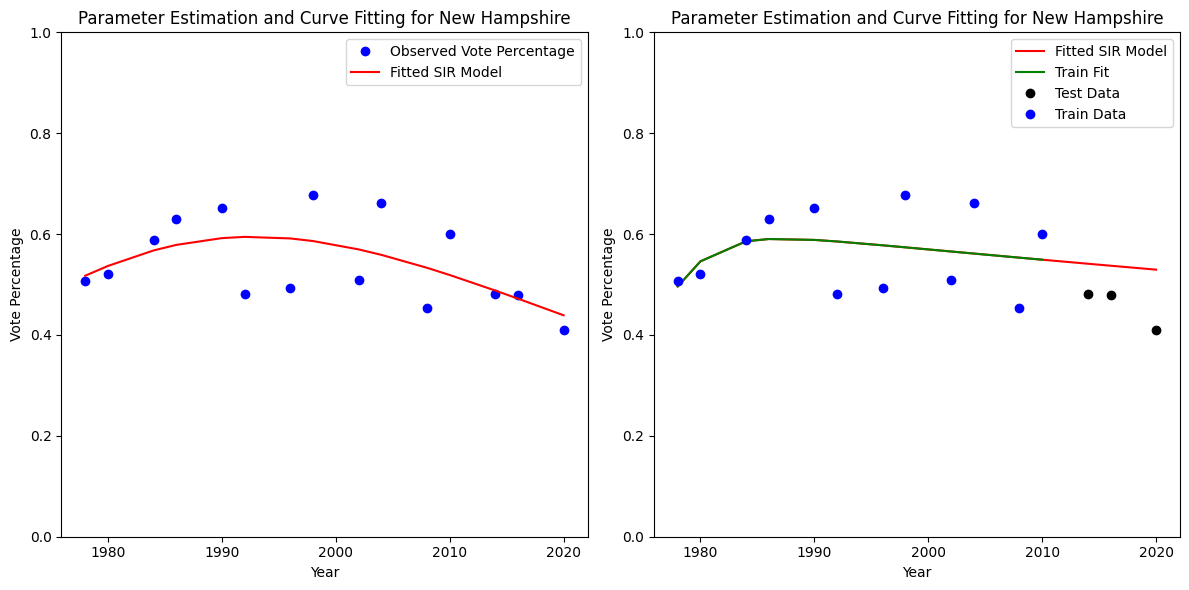

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First plot
axes[0].plot(year, vote_percentage, 'bo', label='Observed Vote Percentage')
axes[0].plot(year, fitted_voter_percentage, 'r-', label='Fitted SIR Model')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Vote Percentage')
axes[0].set_ylim(0, 1)
axes[0].legend()
axes[0].set_title('Parameter Estimation and Curve Fitting for New Hampshire')

# Second plot
axes[1].plot(year, test_fit, 'r-', label='Fitted SIR Model')
axes[1].plot(X_train, fit_sir_model(X_train, *params), 'g-', label='Train Fit')
axes[1].plot(X_test, y_test, 'ko', label='Test Data')
axes[1].plot(X_train, y_train, 'bo', label='Train Data')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Vote Percentage')
axes[1].set_ylim(0, 1)
axes[1].legend()
axes[1].set_title('Parameter Estimation and Curve Fitting for New Hampshire')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## TO DO
- clean the data frame to get more data. 
- Train-test split | Cross Validate
- Get optimum parameters for different guesses. 
- Can try different estimations
- ADD MORE REALISTIC PARAMETERS TO THE MODEL 

In [19]:
year = df_dict[('OREGON', 'REPUBLICAN')]['year'].values
votes = df_dict[('OREGON', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('OREGON', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes
split_index = int(0.8 * len(year))

X_train, X_test = year[:split_index], year[split_index:]
y_train, y_test = vote_percentage[:split_index], vote_percentage[split_index:]
I0 = vote_percentage[0]
S0 = 1 - I0
R0 = 0

# fit the curve provided initial guess. 0.1 each | Gives local optimum
params, covariance = curve_fit(fit_sir_model, X_train, y_train, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
beta, gamma = params[:2]
test_fit = (fit_sir_model(year, *params))
print(f"Fitted parameters: beta={beta}, gamma={gamma}")

Fitted parameters: beta=0.4666418583578674, gamma=0.01909952616941452


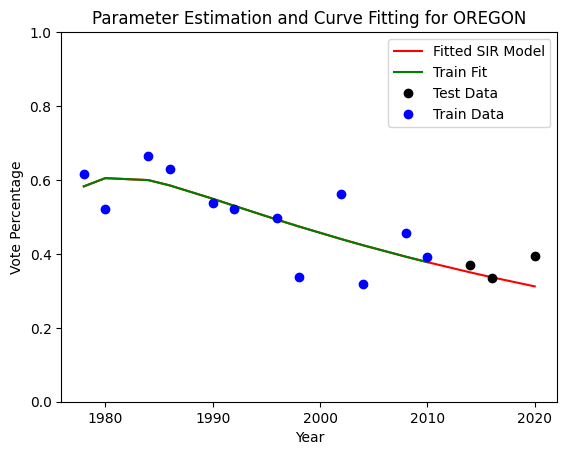

In [20]:
plt.plot(year, test_fit, 'r-', label='Fitted SIR Model')
plt.plot(X_train, fit_sir_model(X_train, *params), 'g-', label='Train Fit')
plt.plot(X_test, y_test, 'ko', label='Test Data')
plt.plot(X_train, y_train, 'bo', label='Train Data')
plt.xlabel('Year')
plt.ylabel('Vote Percentage')
plt.ylim(0, 1)
plt.legend()
plt.title('Parameter Estimation and Curve Fitting for OREGON')
plt.show()

# Running for other states and parties

In [21]:
selected_states = ['NEW HAMPSHIRE', 'NORTH CAROLINA', 'OKLAHOMA', 'OREGON', 'SOUTH CAROLINA', 'SOUTH DAKOTA']
filtered_df = df[df['state'].isin(selected_states)]

Fitted parameters: beta=0.05437961621978311, gamma=0.03446399192118356 for the state NEW HAMPSHIRE and party REPUBLICAN
Fitted parameters: beta=0.005354808264849727, gamma=3.6105930129196283e-10 for the state NEW HAMPSHIRE and party DEMOCRAT
Fitted parameters: beta=5.4468594745835664e-08, gamma=0.001353707023072259 for the state NORTH CAROLINA and party REPUBLICAN
Fitted parameters: beta=0.9999999997747073, gamma=0.0010870326336350742 for the state NORTH CAROLINA and party DEMOCRAT
Fitted parameters: beta=0.03995613292777673, gamma=0.011846148522003433 for the state OKLAHOMA and party REPUBLICAN
Fitted parameters: beta=0.3522694521782574, gamma=0.02737286108756838 for the state OKLAHOMA and party DEMOCRAT
Fitted parameters: beta=0.5511528126244002, gamma=0.016392618712990678 for the state OREGON and party REPUBLICAN
Fitted parameters: beta=0.03470691317176693, gamma=0.014649297120569102 for the state OREGON and party DEMOCRAT
Fitted parameters: beta=0.020089020398668216, gamma=0.011249

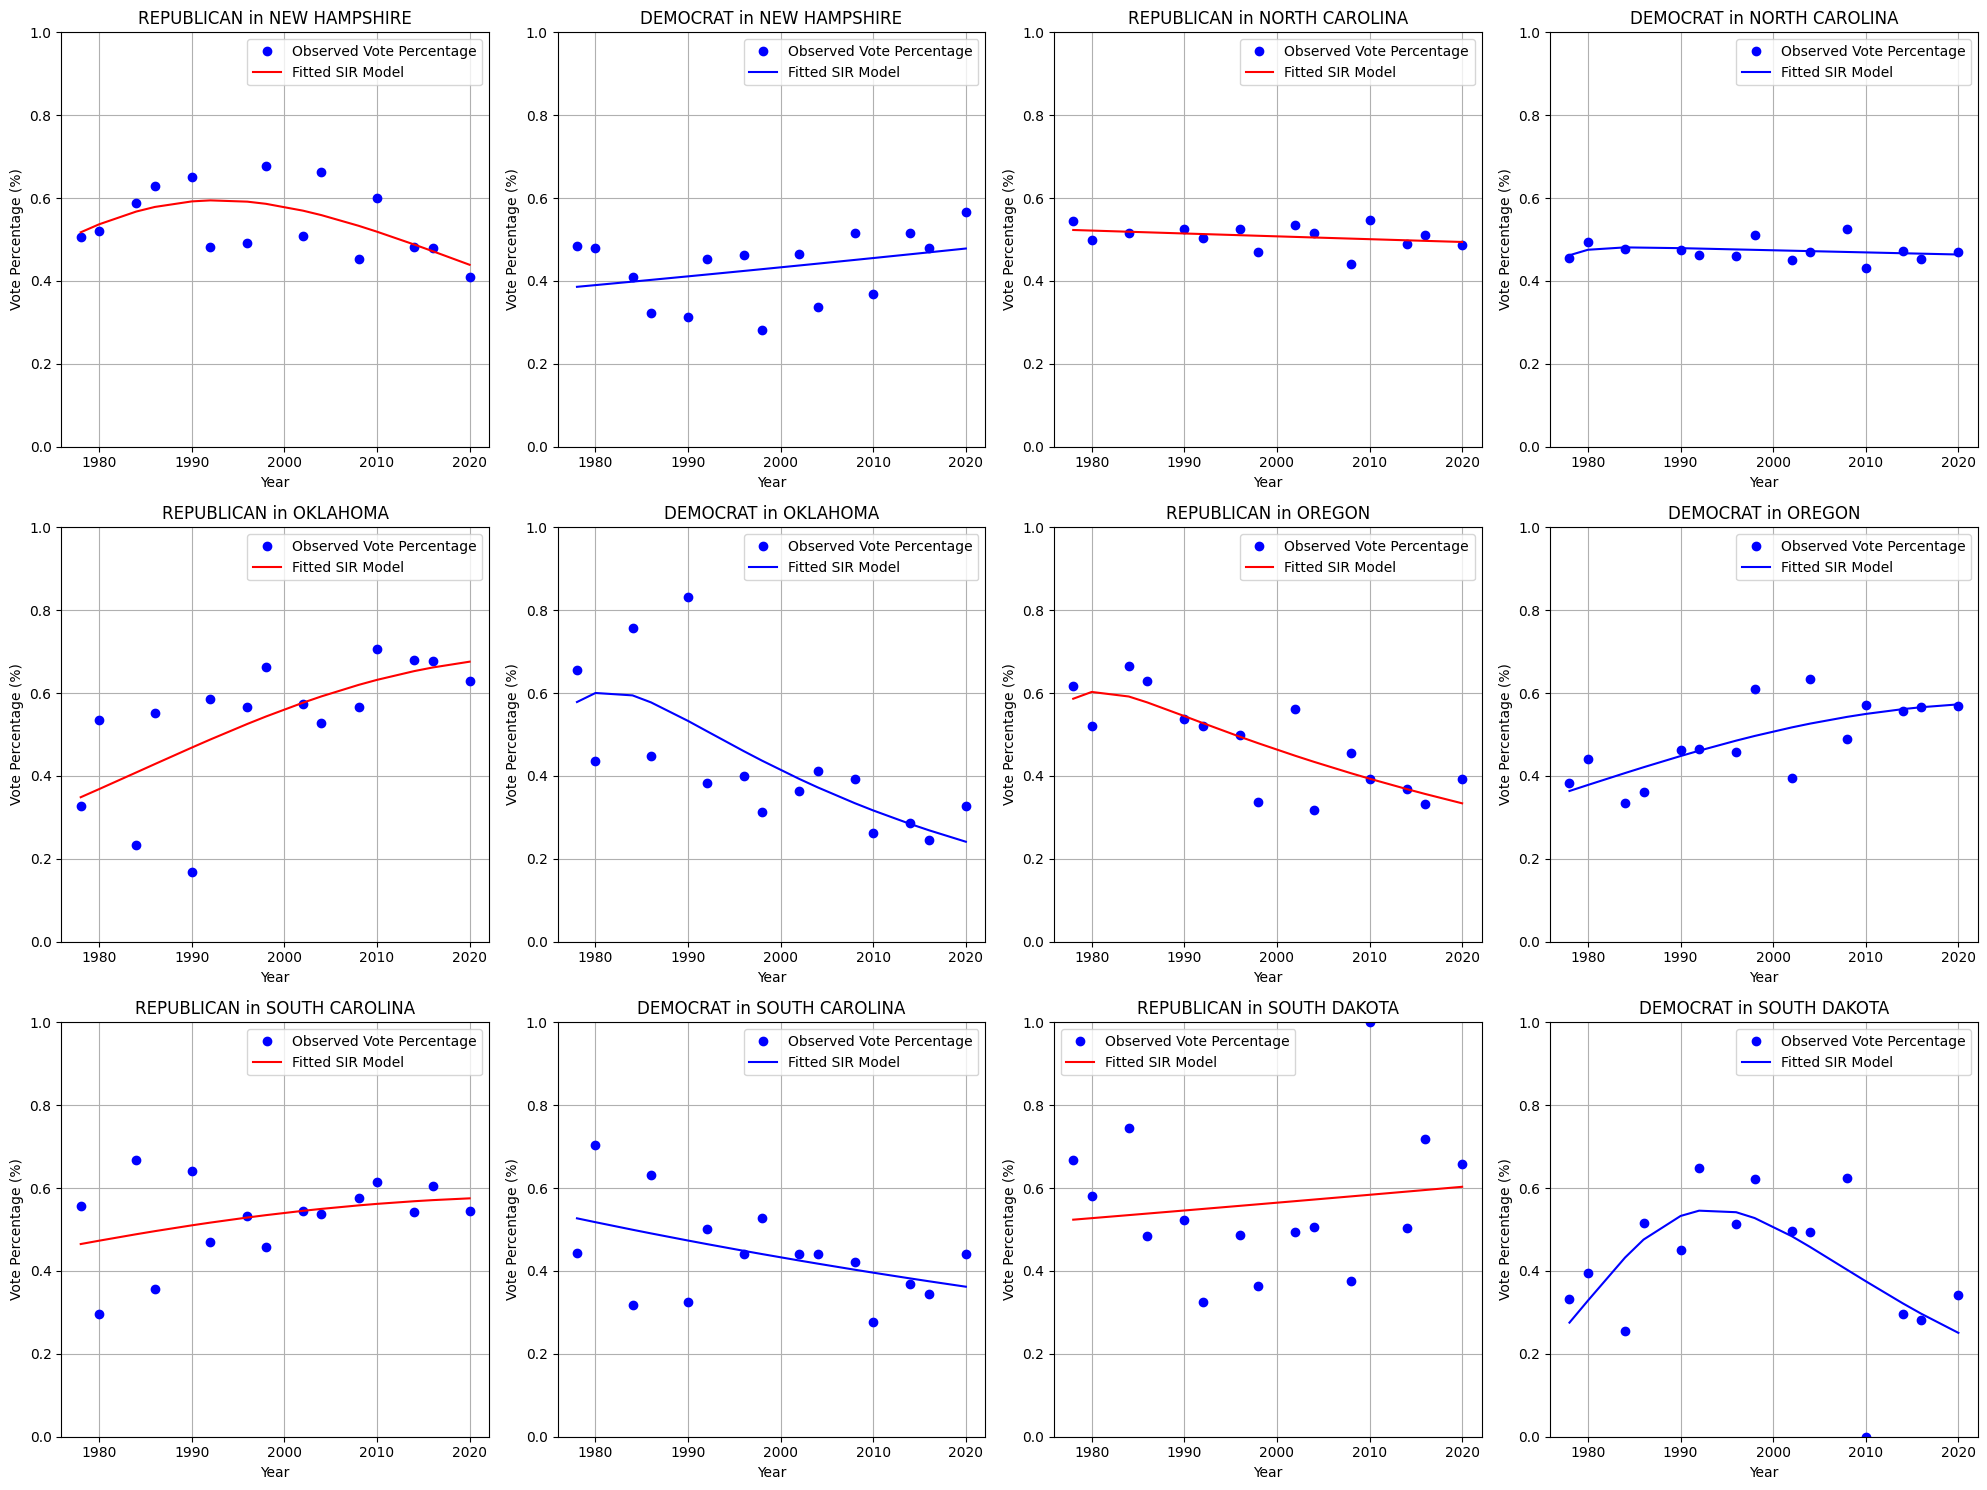

In [22]:
num_plots = len(states) * len(party_order)
cols = 4  # Number of columns in the grid
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
axes = axes.flatten()
ssr = {}
plot_index = 0
for state in states:
    for party in party_order:
        index = (state, party)
        year = df_dict[index]['year'].values
        votes = df_dict[index]['candidatevotes'].values
        total_votes = df_dict[index]['totalvotes'].values
        vote_percentage = votes / total_votes
        I0 = vote_percentage[0]
        S0 = 1 - I0
        R0 = 0

        # fit the curve provided initial guess. 0.1 each | Gives local optimum
        params, covariance = curve_fit(fit_sir_model, year, vote_percentage, p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
        beta, gamma = params[:2]
        print(f"Fitted parameters: beta={beta}, gamma={gamma} for the state {state} and party {party}")
        fitted_voter_percentage = fit_sir_model(year, *params)
        ssr[index] = np.sqrt(np.mean(np.dot((fitted_voter_percentage - vote_percentage).T, (fitted_voter_percentage - vote_percentage)))) * 100
        ax = axes[plot_index]
        ax.plot(year, vote_percentage, 'bo', label='Observed Vote Percentage')
        ax.plot(year, fitted_voter_percentage, label='Fitted SIR Model', color=colors[party])
        ax.set_title(f'{party} in {state}')
        ax.set_xlabel('Year')
        ax.set_ylabel('Vote Percentage (%)')
        ax.set_ylim(0, 1)
        ax.legend()
        ax.grid(True)
        plot_index += 1
        
for i in range(plot_index, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [23]:
ssr

{('NEW HAMPSHIRE', 'REPUBLICAN'): np.float64(25.76717620921564),
 ('NEW HAMPSHIRE', 'DEMOCRAT'): np.float64(30.274414048891984),
 ('NORTH CAROLINA', 'REPUBLICAN'): np.float64(10.082360386439674),
 ('NORTH CAROLINA', 'DEMOCRAT'): np.float64(8.781055520907787),
 ('OKLAHOMA', 'REPUBLICAN'): np.float64(45.29631304543646),
 ('OKLAHOMA', 'DEMOCRAT'): np.float64(46.6034809716443),
 ('OREGON', 'REPUBLICAN'): np.float64(26.19044718756916),
 ('OREGON', 'DEMOCRAT'): np.float64(23.805486528259728),
 ('SOUTH CAROLINA', 'REPUBLICAN'): np.float64(35.110012066066076),
 ('SOUTH CAROLINA', 'DEMOCRAT'): np.float64(38.45979553948994),
 ('SOUTH DAKOTA', 'REPUBLICAN'): np.float64(64.53762877486156),
 ('SOUTH DAKOTA', 'DEMOCRAT'): np.float64(51.82284450371532)}

# Predator Prey model

In [53]:
df

,year,state,state_po,state_fips,state_cen,state_ic,office,district,stage,special,candidate,party_detailed,writein,mode,candidatevotes,totalvotes,unofficial,version,party_simplified
0,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,SAM STEIGER,REPUBLICAN,False,total,321236,741210,False,20210114,REPUBLICAN
1,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,WM. MATHEWS FEIGHAN,INDEPENDENT,False,total,1565,741210,False,20210114,OTHER
2,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,DENNIS DECONCINI,DEMOCRAT,False,total,400334,741210,False,20210114,DEMOCRAT
3,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,ALLAN NORWITZ,LIBERTARIAN,False,total,7310,741210,False,20210114,LIBERTARIAN
4,1976,ARIZONA,AZ,4,86,61,US SENATE,statewide,gen,False,BOB FIELD,INDEPENDENT,False,total,10765,741210,False,20210114,OTHER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3625,2020,WYOMING,WY,56,83,68,US SENATE,statewide,gen,False,UNDER VOTES,NaN,False,total,6401,278503,False,20210114,OTHER
3626,2021,GEORGIA,GA,13,58,44,US SENATE,statewide,runoff,True,KELLY LOEFFLER,REPUBLICAN,False,total,2194848,4483294,True,20210114,REPUBLICAN
3627,2021,GEORGIA,GA,13,58,44,US SENATE,statewide,runoff,True,RAPHAEL WARNOCK,DEMOCRAT,False,total,2288446,4483294,True,20210114,DEMOCRAT
3628,2021,GEORGIA,GA,13,58,44,US SENATE,statewide,runoff,False,DAVID A. PERDUE,REPUBLICAN,False,total,2213979,4483241,True,20210114,REPUBLICAN


In [54]:
df
df_mod = df[df['stage'] == 'gen']
df_mod = df_mod[df_mod['party_simplified'].isin(['REPUBLICAN', 'DEMOCRAT'])]
grouped = df_mod.groupby(['year', 'party_simplified'])['candidatevotes'].sum().unstack().fillna(0)
grouped['Total'] = grouped.sum(axis=1)
grouped['DEMOCRAT_pct'] = 100 * grouped['DEMOCRAT'] / grouped['Total']
grouped['REPUBLICAN_pct'] = 100 * grouped['REPUBLICAN'] / grouped['Total']

In [55]:
years = grouped.index.values
t = years - years[0]
vote_A = grouped['DEMOCRAT_pct'].values
vote_B = grouped['REPUBLICAN_pct'].values
initial_conditions = [vote_A[0], vote_B[0]]

In [56]:
def lotka_volterra(y, t, alpha, beta, delta, gamma):
    x, y_val = y
    dxdt = alpha * x - beta * x * y_val
    dydt = delta * x * y_val - gamma * y_val
    return [dxdt, dydt]

In [ ]:
def modified_lv(y, t, alpha, beta, delta, gamma, K=100):
    x, y_val = y
    dxdt = alpha * x * (1 - x / K) - beta * x * y_val
    dydt = delta * x * y_val - gamma * y_val * (1 - y_val / K)
    return [dxdt, dydt]

In [ ]:
def objective(params):
    alpha, beta, delta, gamma = params
    sol = odeint(modified_lv, initial_conditions, t, args=(alpha, beta, delta, gamma))
    x_model, y_model = sol.T
    return np.sum((vote_A - x_model)**2 + (vote_B - y_model)**2)

In [65]:
initial_guess = [1e-5, 1e-5, 1e-5, 1e-5]
bounds = [(0, 1)] * 4
result = minimize(objective, initial_guess, bounds=bounds)
alpha, beta, delta, gamma = result.x
print(f"Fitted parameters: alpha={alpha:.4f}, beta={beta:.4f}, delta={delta:.4f}, gamma={gamma:.4f}")

Fitted parameters: alpha=0.0000, beta=0.0001, delta=0.0032, gamma=0.1672


C:\Users\alanr\AppData\Local\Temp\ipykernel_19792\57625936.py:3: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(lotka_volterra, initial_conditions, t, args=(alpha, beta, delta, gamma))


In [66]:
sol = odeint(lotka_volterra, initial_conditions, t, args=(alpha, beta, delta, gamma))
x_model, y_model = sol.T

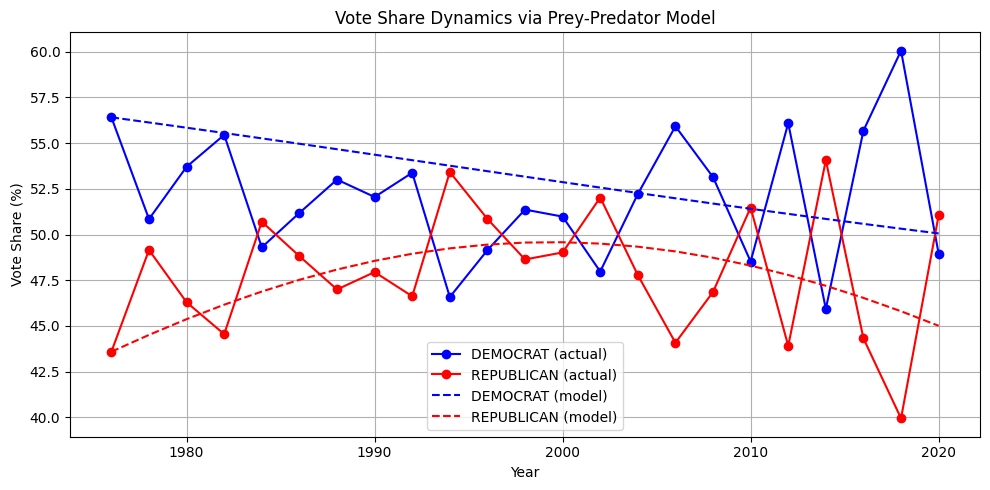

In [67]:
plt.figure(figsize=(10, 5))
plt.plot(years, vote_A, 'bo-', label="DEMOCRAT (actual)")
plt.plot(years, vote_B, 'ro-', label="REPUBLICAN (actual)")
plt.plot(years, x_model, 'b--', label="DEMOCRAT (model)")
plt.plot(years, y_model, 'r--', label="REPUBLICAN (model)")
plt.xlabel("Year")
plt.ylabel("Vote Share (%)")
plt.title("Vote Share Dynamics via Prey-Predator Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ARIMA


In [68]:
from statsmodels.tsa.arima.model import ARIMA

In [75]:
dem_votes = grouped['DEMOCRAT_pct']

# Fit ARIMA model (p=1, d=1, q=1 as example)
model = ARIMA(dem_votes, order=(1,1,1))
model_fit = model.fit()

forecast = model_fit.predict(start=0, end=len(dem_votes)-1, typ='levels')

C:\Users\alanr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\alanr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\alanr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, 

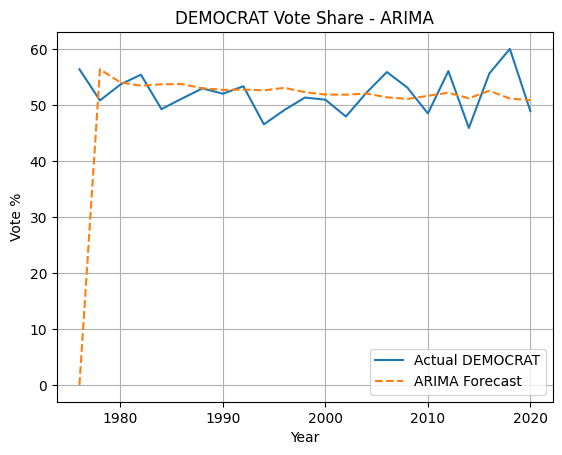

In [76]:
plt.plot(dem_votes.index, dem_votes, label='Actual DEMOCRAT')
plt.plot(dem_votes.index, forecast, label='ARIMA Forecast', linestyle='--')
plt.legend()
plt.title("DEMOCRAT Vote Share - ARIMA")
plt.xlabel("Year")
plt.ylabel("Vote %")
plt.grid(True)
plt.show()

# VAR

In [77]:
from statsmodels.tsa.api import VAR

In [79]:
vote_df = grouped[['DEMOCRAT_pct', 'REPUBLICAN_pct']]

model = VAR(vote_df)
results = model.fit(maxlags=2)

lag_order = results.k_ar
forecast_input = vote_df.values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=len(vote_df))

C:\Users\alanr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [80]:
forecast_df = pd.DataFrame(forecast, columns=['DEMOCRAT_forecast', 'REPUBLICAN_forecast'], index=vote_df.index)

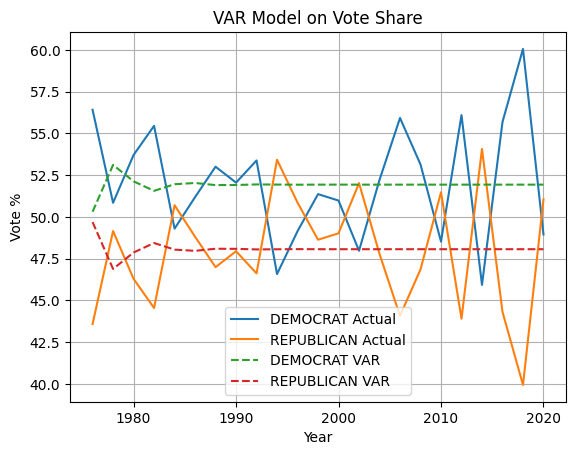

In [81]:
plt.plot(vote_df.index, vote_df['DEMOCRAT_pct'], label='DEMOCRAT Actual')
plt.plot(vote_df.index, vote_df['REPUBLICAN_pct'], label='REPUBLICAN Actual')
plt.plot(vote_df.index, forecast_df['DEMOCRAT_forecast'], '--', label='DEMOCRAT VAR')
plt.plot(vote_df.index, forecast_df['REPUBLICAN_forecast'], '--', label='REPUBLICAN VAR')
plt.title("VAR Model on Vote Share")
plt.xlabel("Year")
plt.ylabel("Vote %")
plt.legend()
plt.grid(True)
plt.show()

# Neural ODE

In [87]:
import torch
import torch.nn as nn
from torchdiffeq import odeint

In [88]:
class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )
    def forward(self, t, y):
        return self.net(y)


In [89]:
y0 = torch.tensor([vote_df.iloc[0].values], dtype=torch.float32)
t = torch.linspace(0, len(vote_df)-1, len(vote_df))
y_data = torch.tensor(vote_df.values, dtype=torch.float32)

C:\Users\alanr\AppData\Local\Temp\ipykernel_19792\2638541814.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  y0 = torch.tensor([vote_df.iloc[0].values], dtype=torch.float32)


In [90]:
func = ODEFunc()
optimizer = torch.optim.Adam(func.parameters(), lr=0.01)

In [91]:
for epoch in range(1000):
    pred_y = odeint(func, y0[0], t)
    loss = torch.mean((pred_y - y_data)**2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 99.5052
Epoch 100, Loss: 11.3780
Epoch 200, Loss: 11.3214
Epoch 300, Loss: 11.2683
Epoch 400, Loss: 11.2235
Epoch 500, Loss: 11.1806
Epoch 600, Loss: 11.1376
Epoch 700, Loss: 11.1093
Epoch 800, Loss: 11.0911
Epoch 900, Loss: 11.0771


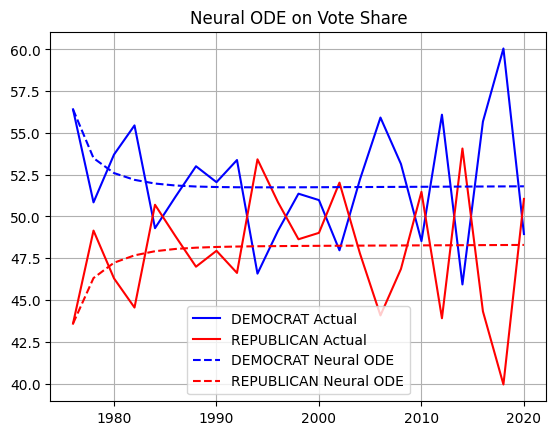

In [92]:
pred = pred_y.detach().numpy()
plt.plot(vote_df.index, vote_df['DEMOCRAT_pct'], 'b', label='DEMOCRAT Actual')
plt.plot(vote_df.index, vote_df['REPUBLICAN_pct'], 'r', label='REPUBLICAN Actual')
plt.plot(vote_df.index, pred[:,0], 'b--', label='DEMOCRAT Neural ODE')
plt.plot(vote_df.index, pred[:,1], 'r--', label='REPUBLICAN Neural ODE')
plt.title("Neural ODE on Vote Share")
plt.legend()
plt.grid(True)
plt.show()

# S curve

In [93]:
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

In [94]:
x = np.array(t)
y = vote_A

C:\Users\alanr\AppData\Local\Temp\ipykernel_19792\4236256900.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x = np.array(t)


In [95]:
params, _ = curve_fit(logistic, x, y, p0=[60, 0.2, 10])
L, k, x0 = params

In [96]:
y_fit = logistic(x, L, k, x0)

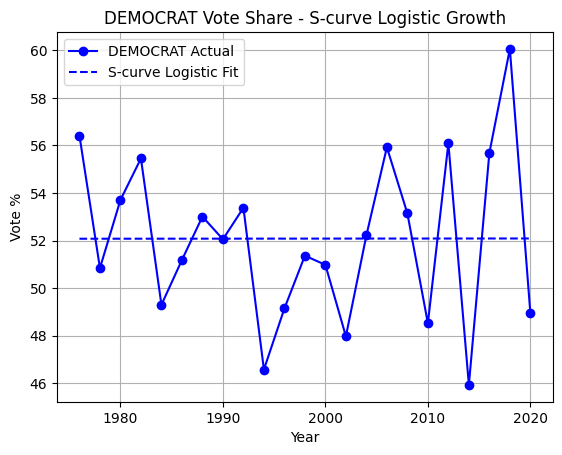

In [97]:
plt.plot(years, y, 'bo-', label="DEMOCRAT Actual")
plt.plot(years, y_fit, 'b--', label="S-curve Logistic Fit")
plt.title("DEMOCRAT Vote Share - S-curve Logistic Growth")
plt.xlabel("Year")
plt.ylabel("Vote %")
plt.grid(True)
plt.legend()
plt.show()

# PINNS

In [102]:
D = vote_A # dem

In [103]:
R = vote_B # rep

In [101]:
t = (years - years[0]) / (years[-1] - years[0])

In [104]:
t = torch.tensor(t, dtype=torch.float32).unsqueeze(1).requires_grad_(True)
D = torch.tensor(D / 100.0, dtype=torch.float32).unsqueeze(1)
R = torch.tensor(R / 100.0, dtype=torch.float32).unsqueeze(1)

In [105]:
Y = torch.cat([D, R], dim=1)

In [106]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 2)
        )

    def forward(self, t):
        return self.net(t)


In [107]:
def pinn_loss(model, t, y_obs):
    y_pred = model(t)
    D_pred, R_pred = y_pred[:, 0:1], y_pred[:, 1:2]

    # Compute derivatives w.r.t time
    dydt = torch.autograd.grad(y_pred, t, grad_outputs=torch.ones_like(y_pred),
                               retain_graph=True, create_graph=True)[0]
    dDdt = dydt[:, 0:1]
    dRdt = dydt[:, 1:2]

    # Physics-inspired constraints (example: prey-predator like dynamics)
    f1 = dDdt - (D_pred * (1 - D_pred) - D_pred * R_pred)
    f2 = dRdt - (-R_pred + D_pred * R_pred)

    # Loss: data fitting + physics constraint
    data_loss = torch.mean((y_pred - y_obs)**2)
    physics_loss = torch.mean(f1**2) + torch.mean(f2**2)
    return data_loss + physics_loss, data_loss.detach(), physics_loss.detach()


In [108]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [109]:
for epoch in range(5000):
    optimizer.zero_grad()
    loss, data_l, phys_l = pinn_loss(model, t, Y)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Total Loss={loss.item():.6f}, Data={data_l:.6f}, Physics={phys_l:.6f}")


Epoch 0: Total Loss=nan, Data=0.304174, Physics=nan
Epoch 500: Total Loss=nan, Data=0.001075, Physics=nan
Epoch 1000: Total Loss=nan, Data=0.001046, Physics=nan
Epoch 1500: Total Loss=nan, Data=0.001039, Physics=nan
Epoch 2000: Total Loss=nan, Data=0.001038, Physics=nan
Epoch 2500: Total Loss=nan, Data=0.001037, Physics=nan
Epoch 3000: Total Loss=nan, Data=0.001036, Physics=nan
Epoch 3500: Total Loss=nan, Data=0.001035, Physics=nan
Epoch 4000: Total Loss=nan, Data=0.001034, Physics=nan
Epoch 4500: Total Loss=nan, Data=0.001033, Physics=nan


In [110]:
with torch.no_grad():
    pred = model(t)
    D_pred = pred[:, 0].numpy() * 100
    R_pred = pred[:, 1].numpy() * 100

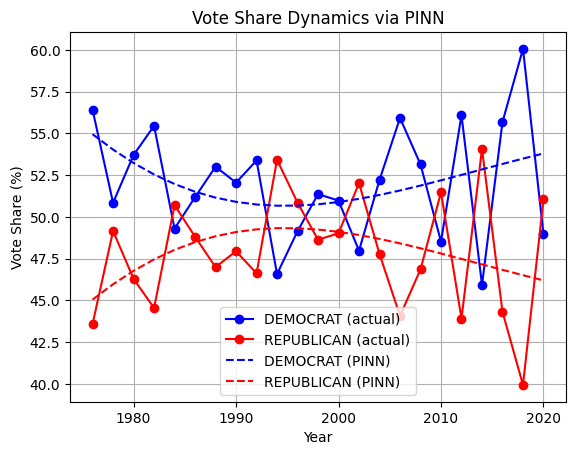

In [111]:
plt.plot(years, D.numpy().squeeze() * 100, 'bo-', label='DEMOCRAT (actual)')
plt.plot(years, R.numpy().squeeze() * 100, 'ro-', label='REPUBLICAN (actual)')
plt.plot(years, D_pred, 'b--', label='DEMOCRAT (PINN)')
plt.plot(years, R_pred, 'r--', label='REPUBLICAN (PINN)')
plt.xlabel("Year")
plt.ylabel("Vote Share (%)")
plt.legend()
plt.title("Vote Share Dynamics via PINN")
plt.grid(True)
plt.show()

# Evolutionary algorithm

In [25]:
from deap import base, creator, tools, algorithms

In [26]:
def run_ga(data_I, t, N):
    # Define the problem as a minimization problem
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize fitness
    creator.create("Individual", list, fitness=creator.FitnessMin)

    # Initialize the individual and population
    def create_individual():
        return [random.uniform(0, 1) for _ in range(2)]  # Beta and Gamma values

    # Register the components for the GA
    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", fitness_function, t=t, data_I=data_I, N=N)

    # Create the population
    population = toolbox.population(n=50)

    # Set the parameters for the genetic algorithm
    ngen = 100  # number of generations
    cxpb = 0.7  # probability of mating
    mutpb = 0.2  # probability of mutation

    # Run the genetic algorithm
    algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=ngen, 
                        stats=None, halloffame=None, verbose=True)

    # Extract the best individual (solution)
    best_individual = tools.selBest(population, 1)[0]
    return best_individual

In [27]:
N = 10000
best_params = run_ga(vote_percentage, year, N)
beta, gamma = best_params
print(f"Best parameters from GA: beta={beta}, gamma={gamma}")
ea_fit = (fit_sir_model(year, *params))

gen	nevals
0  	50    
1  	40    
2  	38    
3  	41    
4  	36    
5  	37    
6  	32    
7  	40    
8  	42    
9  	41    
10 	37    
11 	29    
12 	39    
13 	44    
14 	42    
15 	33    
16 	39    
17 	39    
18 	42    
19 	41    
20 	38    
21 	31    
22 	44    
23 	39    
24 	40    
25 	36    
26 	36    
27 	39    
28 	36    
29 	36    
30 	39    
31 	39    
32 	38    
33 	35    
34 	37    
35 	36    
36 	41    
37 	44    
38 	43    
39 	40    
40 	42    
41 	34    
42 	36    
43 	39    
44 	32    
45 	38    
46 	40    
47 	39    
48 	38    
49 	37    
50 	45    
51 	39    
52 	39    
53 	39    
54 	36    
55 	38    
56 	28    
57 	36    
58 	35    
59 	37    
60 	37    
61 	40    
62 	44    
63 	39    
64 	41    
65 	41    
66 	44    
67 	39    
68 	39    
69 	39    
70 	41    
71 	36    
72 	35    
73 	41    
74 	38    
75 	39    
76 	33    
77 	40    
78 	41    
79 	38    
80 	40    
81 	35    
82 	42    
83 	40    
84 	44    
85 	35    
86 	35    
87 	36    
88 	39    
89 	35    

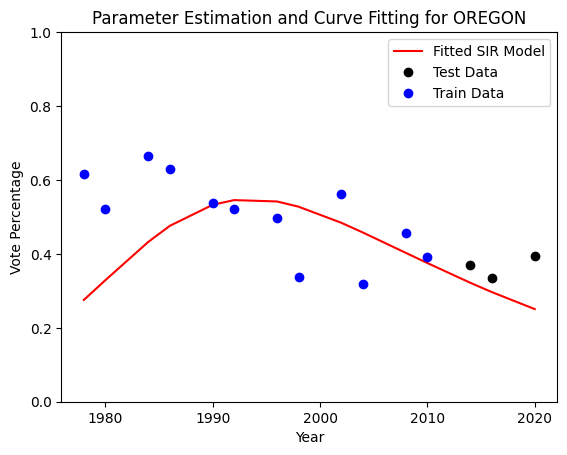

In [28]:
plt.plot(year, ea_fit, 'r-', label='Fitted SIR Model')
# plt.plot(X_train, fit_sir_model(X_train, *params), 'g-', label='Train Fit')
plt.plot(X_test, y_test, 'ko', label='Test Data')
plt.plot(X_train, y_train, 'bo', label='Train Data')
plt.xlabel('Year')
plt.ylabel('Vote Percentage')
plt.ylim(0, 1)
plt.legend()
plt.title('Parameter Estimation and Curve Fitting for OREGON')
plt.show()

# Implementing sliding window parameter fitting

In [29]:
year = df_dict[('OREGON', 'REPUBLICAN')]['year'].values
votes = df_dict[('OREGON', 'REPUBLICAN')]['candidatevotes'].values
total_votes = df_dict[('OREGON', 'REPUBLICAN')]['totalvotes'].values
vote_percentage = votes / total_votes
M = 4
window_length  = int(len(year / M))
beta_array = np.zeros(len(year)-M+1)
gamma_array = np.zeros(len(year)-M+1)
test_fit_array = np.zeros((len(year)-M+1, M))
results = []
for i in range(len(year)-M+1):
    I0 = vote_percentage[i]
    S0 = 1 - I0
    R0 = 0
    params, covariance = curve_fit(fit_sir_model, year[i:i+M], vote_percentage[i:i+M], p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))
    initial_params = [0.1, 0.1]
    res = minimize(loss, initial_params, args=(year[i:i+M], vote_percentage[i:i+M]), bounds=[(0, 2), (0, 2)])
    beta, gamma = res.x
    results.append({
        'start_year':i,
        'end_year': i+M,
        'beta': beta,
        'gamma': gamma
    })
    beta_array[i], gamma_array[i] = params[:2]
    test_fit_array[i, :] = fit_sir_model(year[i:i+M], *params)


C:\Users\alanr\AppData\Local\Temp\ipykernel_19792\2203143884.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  params, covariance = curve_fit(fit_sir_model, year[i:i+M], vote_percentage[i:i+M], p0=[0.1, 0.1, S0, I0, R0], bounds=(0, [1, 1, 1, 1, 1]))


In [30]:
result_df = pd.DataFrame(results)
result_df

,start_year,end_year,beta,gamma
0,0,4,2.0,0.989548
1,1,5,2.0,0.967054
2,2,6,2.0,1.180576
3,3,7,2.0,1.156684
4,4,8,2.0,1.360789
5,5,9,2.0,0.141813
6,6,10,2.0,1.338173
7,7,11,2.0,1.338124
8,8,12,2.0,1.348369
9,9,13,2.0,1.392468


In [31]:
test_fit_array = np.zeros((len(year)-M+1, M))
for i in range(len(year)-M+1):
    I0 = vote_percentage[i]
    S0 = 1 - I0
    R0 = 0
    test_fit_array[i, :] = fit_sir_model(year[i:i+M], result_df['beta'][i], result_df['gamma'][i], S0, I0, R0)

In [32]:
test_fit_array

array([[6.16418941e-01, 1.68086147e-01, 5.35077571e-03, 9.33310048e-04],
       [5.21081216e-01, 3.79623450e-02, 7.35993451e-03, 2.70449245e-04],
       [6.65290784e-01, 1.15569244e-01, 1.84870945e-03, 2.30817949e-04],
       [6.29527459e-01, 1.70694239e-02, 2.29240976e-03, 4.13305910e-05],
       [5.36813569e-01, 9.23681240e-02, 1.16935494e-03, 1.29199591e-04],
       [5.21393746e-01, 5.96572540e-01, 4.50445158e-01, 2.55567183e-01],
       [4.97956963e-01, 9.92432032e-02, 1.50040341e-03, 1.80481756e-04],
       [3.37946780e-01, 1.92698950e-02, 3.00904536e-03, 7.15092349e-05],
       [5.62085856e-01, 9.24550616e-02, 1.12958423e-03, 1.22880241e-04],
       [3.17460335e-01, 1.77198411e-02, 2.72727691e-03, 6.29884637e-05],
       [4.55534471e-01, 8.44164136e-02, 1.07565228e-03, 1.18715630e-04],
       [3.92488361e-01, 1.24449506e-02, 1.58032597e-03, 2.52020512e-05]])

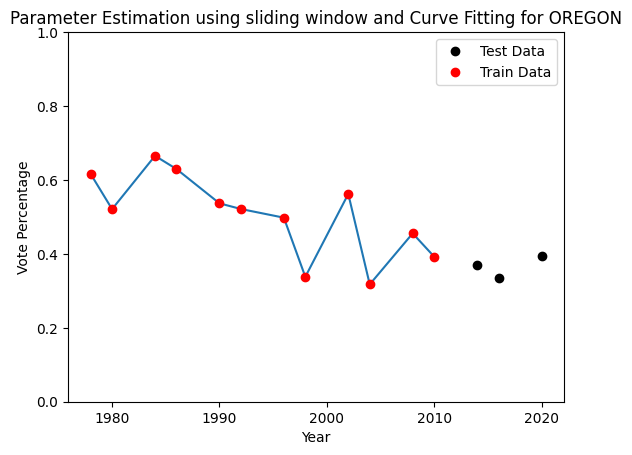

In [33]:
new = test_fit_array.T
plt.plot(year[:12], new[0])
plt.plot(X_test, y_test, 'ko', label='Test Data')

plt.plot(X_train, y_train, 'ro', label='Train Data')
plt.xlabel('Year')
plt.ylabel('Vote Percentage')
plt.ylim(0, 1)
plt.legend()
plt.title('Parameter Estimation using sliding window and Curve Fitting for OREGON')
plt.show()

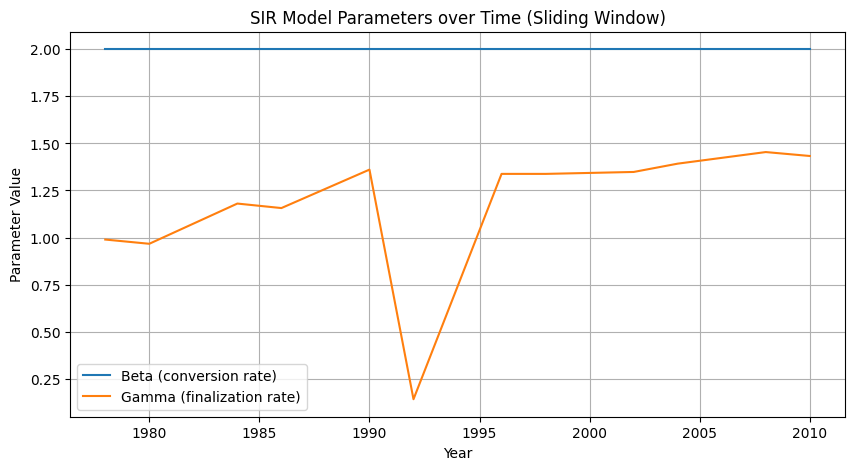

In [34]:
plt.figure(figsize=(10,5))
plt.plot(year[:len(year)-M+1], result_df['beta'], label='Beta (conversion rate)')
plt.plot(year[:len(year)-M+1], result_df['gamma'], label='Gamma (finalization rate)')
plt.xlabel('Year')
plt.ylabel('Parameter Value')
plt.title('SIR Model Parameters over Time (Sliding Window)')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
future_steps = 9
beta_vals = result_df['beta']
gamma_vals = result_df['gamma']
model_beta = ARIMA(beta_vals, order=(1, 1, 0))
results_beta = model_beta.fit()
beta_forecast = results_beta.forecast(steps=future_steps)

model_gamma = ARIMA(gamma_vals, order=(1, 1, 0))
results_gamma = model_gamma.fit()
gamma_forecast = results_gamma.forecast(steps=future_steps)

future_years = np.arange(2012, 2012 + 2*future_steps, 2)

In [37]:
future_years

array([2012, 2014, 2016, 2018, 2020, 2022, 2024, 2026, 2028])

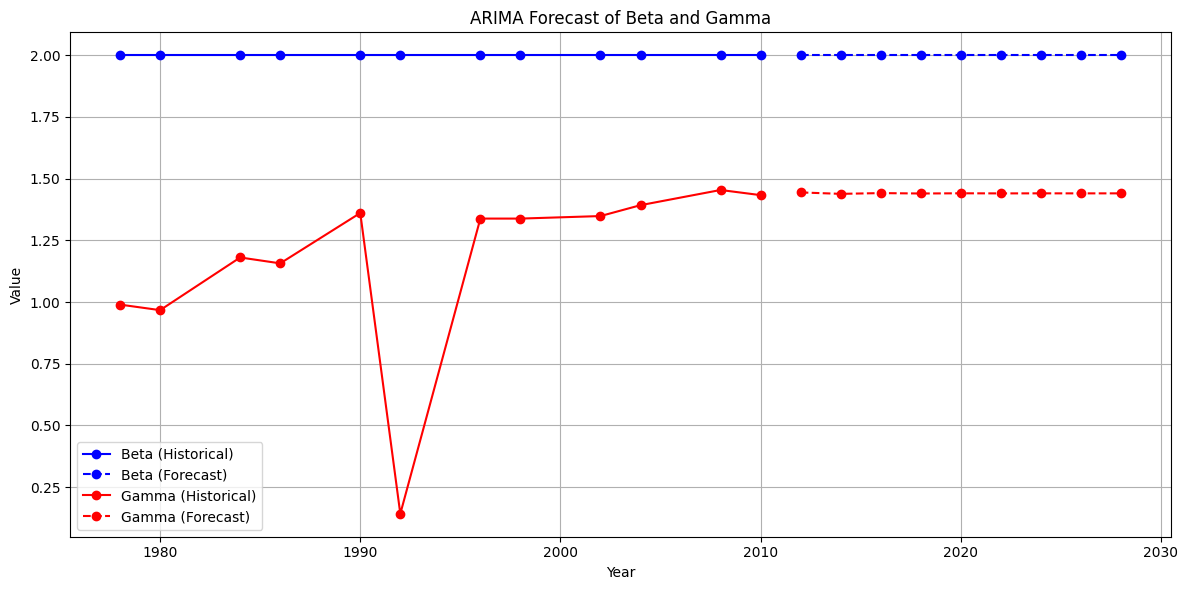

In [38]:
plt.figure(figsize=(12, 6))

# Beta plot
plt.plot(year[:len(year)-M+1], beta_vals, 'bo-', label='Beta (Historical)')
plt.plot(future_years, beta_forecast, 'b--o', label='Beta (Forecast)')

# Gamma plot
plt.plot(year[:len(year)-M+1], gamma_vals, 'ro-', label='Gamma (Historical)')
plt.plot(future_years, gamma_forecast, 'r--o', label='Gamma (Forecast)')

plt.xlabel("Year")
plt.ylabel("Value")
plt.title("ARIMA Forecast of Beta and Gamma")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
from numpy.polynomial import Polynomial

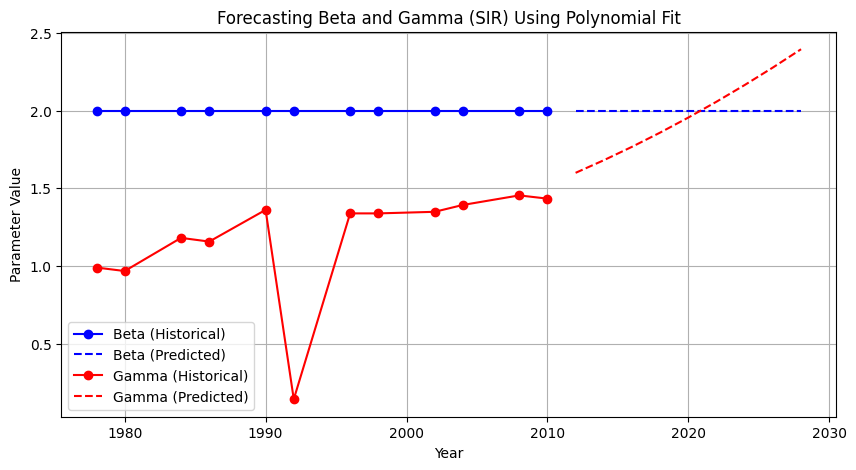

In [40]:
# Fit a degree-2 polynomial (quadratic)
beta_poly = Polynomial.fit(year[:len(year)-M+1], beta_vals, 2)
gamma_poly = Polynomial.fit(year[:len(year)-M+1], gamma_vals, 2)

# Predict for future years
future_years = np.arange(2012, 2030, 2)
beta_pred = beta_poly(future_years)
gamma_pred = gamma_poly(future_years)

# Plot
plt.figure(figsize=(10,5))
plt.plot(year[:len(year)-M+1], beta_vals, 'bo-', label='Beta (Historical)')
plt.plot(future_years, beta_pred, 'b--', label='Beta (Predicted)')
plt.plot(year[:len(year)-M+1], gamma_vals, 'ro-', label='Gamma (Historical)')
plt.plot(future_years, gamma_pred, 'r--', label='Gamma (Predicted)')
plt.xlabel("Year")
plt.ylabel("Parameter Value")
plt.title("Forecasting Beta and Gamma (SIR) Using Polynomial Fit")
plt.legend()
plt.grid(True)
plt.show()

In [41]:
future_years[-4:]

array([2022, 2024, 2026, 2028])

In [42]:
year

array([1978, 1980, 1984, 1986, 1990, 1992, 1996, 1998, 2002, 2004, 2008,
       2010, 2014, 2016, 2020])

In [43]:
future_years

array([2012, 2014, 2016, 2018, 2020, 2022, 2024, 2026, 2028])

In [112]:
years

array([1976, 1978, 1980, 1982, 1984, 1986, 1988, 1990, 1992, 1994, 1996,
       1998, 2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016, 2018,
       2020])

In [ ]:
beta = np.concatenate((beta_array, beta_forecast))

gamma = np.concatenate((gamma_array, gamma_forecast))
years = np.concatenate((year[:-1], future_years[-5:]))
years = np.sort(years)

test_fit_array = np.zeros((len(years)-M+1, M))

for i in range(len(years)-M):
    I0 = vote_percentage[i]
    S0 = 1 - I0
    R0 = 0
    test_fit_array[i, :] = fit_sir_model(years[i:i+M], beta[i], gamma[i], S0, I0, R0)

In [ ]:
test_fit = (fit_sir_model(year, *params))


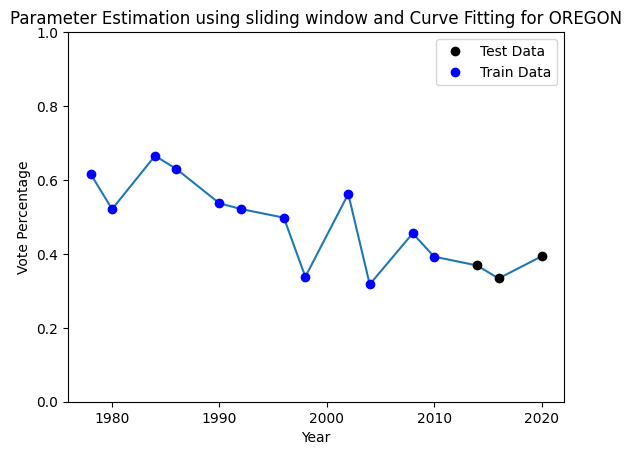

In [ ]:
new = test_fit_array.T
plt.plot(years[:15], new[0][:-1])
plt.plot(X_test, y_test, 'ko', label='Test Data')
plt.plot(X_train, y_train, 'bo', label='Train Data')
plt.xlabel('Year')
plt.ylabel('Vote Percentage')
plt.ylim(0, 1)
plt.legend()
plt.title('Parameter Estimation using sliding window and Curve Fitting for OREGON')
plt.show()

In [ ]:
beta = np.concatenate((beta_array, beta_pred))

gamma = np.concatenate((gamma_array, gamma_pred))
years = np.concatenate((year, future_years[-4:]))
test_fit_array = np.zeros((len(years)-M+1, M))

for i in range(len(years)-M):
    I0 = vote_percentage[i]
    S0 = 1 - I0
    R0 = 0
    test_fit_array[i, :] = fit_sir_model(years[i:i+M], beta[i], gamma[i], S0, I0, R0)

In [ ]:
test_fit = (fit_sir_model(year, *params))

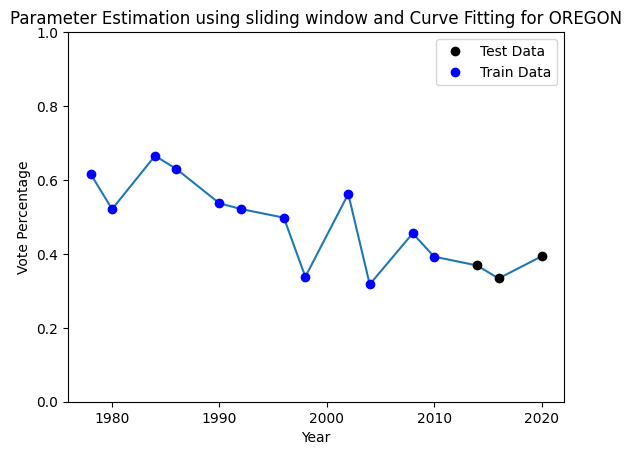

In [ ]:
new = test_fit_array.T
plt.plot(years[:15], new[0][:-1])
plt.plot(X_test, y_test, 'ko', label='Test Data')
plt.plot(X_train, y_train, 'bo', label='Train Data')
plt.xlabel('Year')
plt.ylabel('Vote Percentage')
plt.ylim(0, 1)
plt.legend()
plt.title('Parameter Estimation using sliding window and Curve Fitting for OREGON')
plt.show()